In [2]:
import numpy as np
import pandas as pd
import tqdm

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head(5)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


* id - globally-unique time step identifier across an entire file
* breath_id - globally-unique time step for breaths
* R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
* C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
* time_step - the actual time stamp.
* u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.
* u_out - the control input for the exploratory solenoid valve. Either 0 or 1.
* pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.

In [4]:
test.head(5)

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [5]:
print(train.shape, test.shape)

(6036000, 8) (4024000, 7)


In [6]:
train.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

In [7]:
test.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
dtype: int64

In [14]:
# when u_out > 0: the mean of pressure for each breath_id
g = train[train.u_out>0].groupby(['breath_id'])['pressure'].mean()
g

breath_id
1         7.625978
2         6.776232
3         7.715145
4         7.502774
5         7.193910
            ...   
125740    6.634249
125742    7.585203
125743    6.430842
125745    7.774388
125749    6.790789
Name: pressure, Length: 75450, dtype: float64

In [15]:
train.pressure

0           5.837492
1           5.907794
2           7.876254
3          11.742872
4          12.234987
             ...    
6035995     3.869032
6035996     3.869032
6035997     3.798729
6035998     4.079938
6035999     3.869032
Name: pressure, Length: 6036000, dtype: float64

## Some EDA

<AxesSubplot:xlabel='pressure', ylabel='Count'>

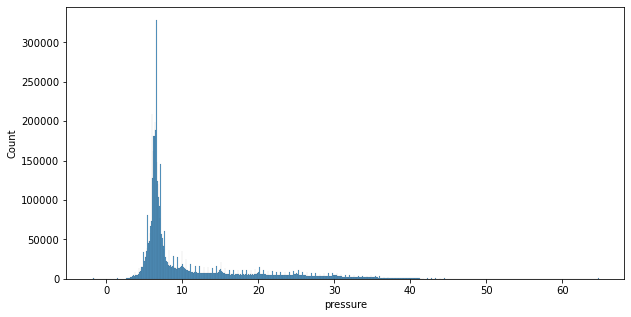

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,1,figsize=(10,5))
sns.histplot(data = train, x="pressure",ax = axes)

### One of the series

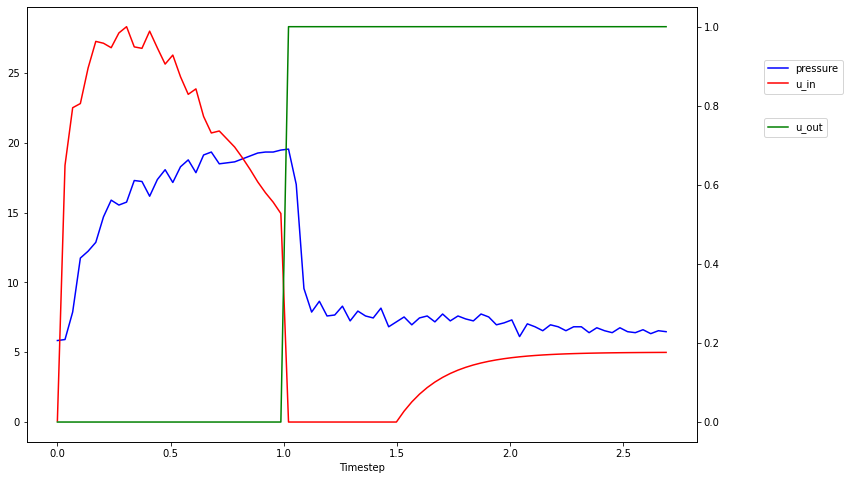

In [8]:
fig, ax1 = plt.subplots(figsize = (12, 8))

breath_1 = train.loc[train['breath_id'] == 1]
ax2 = ax1.twinx()

ax1.plot(breath_1['time_step'], breath_1['pressure'], 'b-', label='pressure')
ax1.plot(breath_1['time_step'], breath_1['u_in'], 'r-', label='u_in')
ax2.plot(breath_1['time_step'], breath_1['u_out'], 'g-', label='u_out')

ax1.set_xlabel('Timestep')

ax1.legend(loc=(1.1, 0.8))
ax2.legend(loc=(1.1, 0.7))
plt.show()

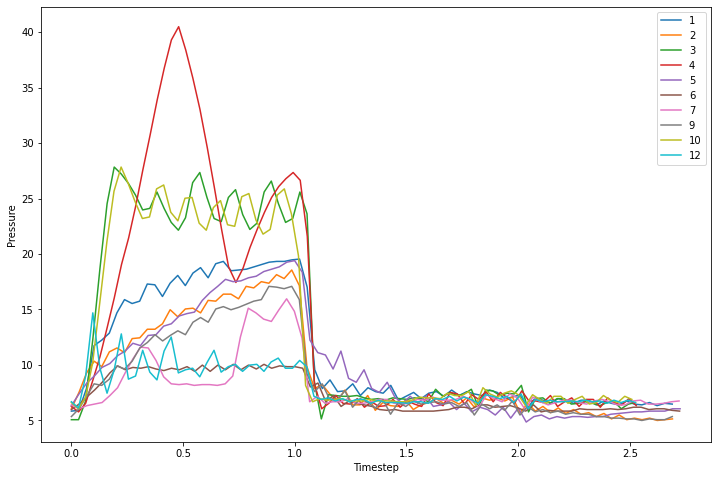

In [12]:
fig, ax1 = plt.subplots(figsize = (12, 8))
for id_ in list(set(train['breath_id']))[:10]:
    breath_id = train.loc[train['breath_id'] == id_]
    ax1.plot(breath_id['time_step'], breath_id['pressure'], label= str(id_))
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Pressure')
ax1.legend()
plt.show()

<AxesSubplot:>

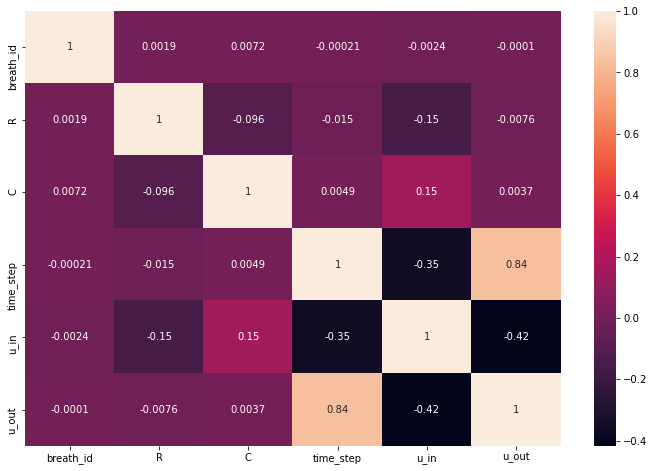

In [9]:
features = ['breath_id','R','C','time_step','u_in','u_out']
corr_matrix = train[features].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True)

### simple RFR

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [10]:
# prac_train = train.sample(n = 500000)
features = ['breath_id','R','C','time_step','u_in','u_out']
X = train[features]
y = train.pressure

# data split to validation
train_X,val_X,train_y,val_y=train_test_split(X,y,random_state=1)

In [11]:
# model = RandomForestRegressor(max_depth = 3, n_jobs = -1, random_state = 1)
model = RandomForestRegressor(max_depth = 10, n_jobs = -1, random_state = 1)

In [12]:
model.fit(train_X, train_y)

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=1)

In [16]:
predictions = model.predict(val_X)
val_mae = mean_absolute_error(predictions, val_y)
print(f"Validation MAE for Random Forest:{val_mae}")

Validation MAE for Random Forest:2.1022358752959693


In [17]:
test_X = test[features]
test_preds = model.predict(test_X)
print(test_preds[0:20])

[ 6.13264093  5.60567274  7.39167016  7.83534062  9.77754298 11.35099483
 11.35099483 17.56979195 17.56979195 17.56979195 17.87328751 20.54026492
 21.09837457 19.62355073 18.36928949 21.63166279 22.67697641 20.16028087
 19.03055298 20.65891781]


In [18]:
output = pd.DataFrame({'id': test.id,'pressure': test_preds})
output.to_csv('submission.csv', index = False)
print('end')

end


## FE

In [ ]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

In [ ]:
train = add_features(train)
train.drop(['id','breath_id'], axis = 1, inplace = True)
train.head()

In [ ]:
# normalise
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

### Random forest with FE

In [ ]:
features = [x for x in train.columns.values if x != 'pressure']
X = train[features]
y = train.pressure

train_X,val_X,train_y,val_y=train_test_split(X,y,random_state=1)

model = RandomForestRegressor(max_depth = 10, n_jobs = -1, random_state = 1)
model.fit(train_X, train_y)

predictions = model.predict(val_X)
val_mae = mean_absolute_error(predictions, val_y)
print(f"Validation MAE for Random Forest:{val_mae}")

In [ ]:
test = pd.read_csv("test.csv")
test = add_features(test)
test = test.drop(['id','breath_id'], axis = 1)
test.head()

In [ ]:
test_preds = model.predict(test)
print(test_preds[0:20])

output = pd.DataFrame({'id': test.id,'pressure': test_preds})
output.to_csv('rf_with_fe.csv', index = False)
print('end')

### xgboost


In [ ]:
xgb_params = {'max_depth': 10, 
              'learning_rate': 0.8245, 
              'n_estimators': 1500, 
              'subsample': 0.6, 
              'colsample_bytree': 0.8, 
              'min_child_weight': 0.5365, 
              'reg_lambda': 0.19887, 
              'reg_alpha': 0.63604,
              'tree_method':'gpu_hist',
              'booster': "gbtree",
              'eval_metric':'mae'} 

In [ ]:
# 5 - fold
folds = KFold(n_splits = 5, random_state = 2021, shuffle = True)

predictions = np.zeros(len(test))

for fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    print(f"Fold: {fold}")
    X_train, X_test = X.iloc[trn_idx], X.iloc[val_idx]
    y_train, y_test = y.iloc[trn_idx], y.iloc[val_idx]

    model = XGBRegressor(**xgb_params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=400, verbose=False)
    pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, pred)
    print(f" mae: {mae}")
    print("-"*50)
    
    predictions += model.predict(test)

predictions /= folds.n_splits

In [ ]:
sample_submission['pressure'] = predictions
sample_submission.to_csv(f'xgboost.csv',index = False)